# Practical Work in AI

In [1]:
# installs necessary libraries

#!pip install pandas

In [2]:
# necessary imports for notebook to run
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Dataset analysis

### 1.1 Structure of processed.csv

As a first step, certain statistics have to be observed on the given dataset in order to see if it is feasible to be sessionized and further used for training sequence-aware recommender systems models [a], such as GRU4Rec. In our work, a sessionized dataset is a dataset which has been split up into interaction sessions, where a specific user interacts with items. A set threshold determines when to split interactions into the next user session. A session always corresponds to one user, and one user can have multiple sessions.

For the analysis, we are working with the "processed.csv" dataset, which contains user-item interactions and represents a pre-processed version of the "new_release_stream.csv" file. A single row in this file looks like the following:

`28,60,188807,1,[0.0],train`

Here, the user with ID 28 listened to the track with ID 60 at timestamp 188807 (measured in seconds from first consumption). The track was listened to over 80% of its length (y = 1). The time interval (measured in hours) between when user 28 interacted with item 60 this time, versus the previous times, is 0.0, meaning it is the first interaction from user 28 to track 60. Based on the train-test-val split done during pre-processing (see `preprocess.py`), this interaction is part of the training set. 

Repetitive behavior is measured via the relational interval column (here [0.0]). Hence, the following lines from the dataset:

`28,60,188807,1,[0.0],train`

`28,60,188977,1,"[0.04722222222222222, 0.0]",train`

`28,60,189155,0,"[0.09666666666666666, 0.049444444444444444]",train`

have the following meaning with regards to the repetitions:

`28,60,188807,1,[0.0],train` = User 28 consumes item 60 for the first time, thus no previous consumptions logged in the relational interval

`28,60,188977,1,"[0.04722222222222222, 0.0]",train` = User 28 consumed item 60 for the first time 188977-188807 = 170s / 60 / 60 = 0.047222hrs ago

`28,60,189155,0,"[0.09666666666666666, 0.049444444444444444]",train` = User 28 consumed item 60 since the last time 189155-188977 = 178s / 60 / 60 = 0.049444hrs ago and for the first time 0.049444444444444444 + 0.04722222222222222 = 0.09666666666666666 hrs ago

### 1.2 Statistical Analysis

The analysis of the dataset is separated into two parts:

- **Global measures**: e.g. average count of user-item interactions per set, average count of user-item interactions per item, etc.
- **Session-based measures**: e.g. average number of sessions per user, average number of interactions per session, etc.

Global measures are metrics which are interesting in terms of the whole dataset, without (yet) any focus on sessions. These statistics are based on the dataset as a whole. Session-based measures, as the name suggests, are evaluated on a previously sessionized dataset.

We start by reading in the data:

In [4]:
file_path = 'G:\My Drive\JKU\practical_work\Practical-Work-AI\data\processed.csv' # adjust as needed
df = pd.read_csv(file_path)

At first, we focus on global measures which concern the whole dataset.

#### 1.2.1 Global measures

We observe the number of interactions, unique users and unique items in the dataset:

In [5]:
print("Number of user-item interactions in total: ", len(df))
print("Number of unique users: ", df.userId.nunique())
print("Number of unique songs: ", df.itemId.nunique())

Number of user-item interactions in total:  243635
Number of unique users:  463
Number of unique songs:  879


These numbers are consistent with the reportings from [b], after the authors implemented a $k^{item}$ and a $k^{user}$ pre-processing step, where each user has to have interacted with at least $k^{item}$ items and every item has to have been consumed by $k^{user}$ users. They decided on $k^{item} = k^{user} = 30$. For details, see [b], pp. 975.

##### **Number of total user-item interactions per set**

The following table shows the number of interactions per set (training, validation, and test). These are pre-determined by the 'set'-column, which is filled during the pre-processing step.

In [6]:
# count number of rows per set, aka count size of training, test and validation dataset
set_counts = df['set'].value_counts()

# create df outof series and rename columns accordingly
set_counts = set_counts.reset_index(name='n_interactions')

print("Number of user-item interactions for training-, test-, and validation set:")
set_counts


Number of user-item interactions for training-, test-, and validation set:


,index,n_interactions
0,train,170321
1,test,49160
2,val,24154


As we can see, after splitting the data, we have train = ~1.4m, test = ~80.1k and validation = ~79.7k interactions. 

##### **Interest score distribution across sets**

We can now split up the number of interactions based on various criteria we want to observe. For example, this table shows the interest distribution across the different sets. The authors use the $y$ variable, where $y=1$ if the user has listened to more than 80% of the track, and $y=0$ otherwise, as target values for the interest. Namely, if $y=1$, then the interest score for that interaction is equal to 1, meaning the user is interested in the item. These are then used as the target variables in the test set. During training, interest scores ranging from 0 to 1 are obtained. These are then converted to 1 if the score >= 0.5, or 0 otherwise; and then compared to the target interest scores during evaluation.

In [7]:
listening_events = df.groupby(['set', 'y']).size().reset_index(name='n_interactions')
listening_events

,set,y,n_interactions
0,test,0,23671
1,test,1,25489
2,train,0,79301
3,train,1,91020
4,val,0,11896
5,val,1,12258


We observe a pretty even distribution of the binary interest variable across the sets, with slightly more "interested" interactions than "not interested" interactions.

##### **Average number of interactions per user, in total and per set**

The interactions can also be averaged per user or per item, and further split into a more useful statistic - the average number of interactions per user/item for each set. This lets us know if each set has enough data per user/item in it. We also observe how many tracks the user is interested in within all interactions.

In [8]:
user_interaction_counts = df.groupby('userId').size() # per userId, count the interactions
avg_user_counts = user_interaction_counts.mean() # average interaction counts over all users

print(f"On average, a user has {round(avg_user_counts, 1)} item interactions in total with the following interest distribution:")

user_interaction_counts_interest_scores = df.groupby(['userId', 'y']).size().reset_index(name='n_interactions')
user_interaction_counts_interest_scores.groupby('y')['n_interactions'].mean().round(1).reset_index(name='n_interactions')

On average, a user has 526.2 item interactions in total with the following interest distribution:


,y,n_interactions
0,0,248.1
1,1,278.1


On average, users have around 437 interactions and actually listen to (= are interested in) roughly half of the tracks of all interactions.

In [9]:
user_interaction_counts_per_set = df.groupby(['set', 'userId', 'y']).size().reset_index(name='n_interactions')

user_interaction_counts_per_set = user_interaction_counts_per_set.groupby(['set', 'y'])['n_interactions'].mean().round(1).reset_index(name='n_interactions')

print("On average, a user has the following numbers of interactions per set:")
user_interaction_counts_per_set

On average, a user has the following numbers of interactions per set:


,set,y,n_interactions
0,test,0,51.1
1,test,1,55.1
2,train,0,171.3
3,train,1,196.6
4,val,0,25.7
5,val,1,26.9


##### **Average number of interactions per item, in total and per set**

In [10]:
item_interaction_counts = df['itemId'].value_counts() # per track, count the interactions
avg_item_counts = item_interaction_counts.mean() # average interaction counts over all items

print(f"On average, an item is interacted with {round(avg_item_counts, 1)} times, split into the following interest distribution:")

item_interaction_counts_interest_scores = df.groupby(['itemId', 'y']).size().reset_index(name='n_interactions')
item_interaction_counts_interest_scores.groupby('y')['n_interactions'].mean().round(1).reset_index(name='n_interactions')

On average, an item is interacted with 277.2 times, split into the following interest distribution:


,y,n_interactions
0,0,130.7
1,1,146.5


In [11]:
item_interaction_counts_per_set = df.groupby(['set', 'itemId', 'y']).size()

item_interaction_counts_per_set = item_interaction_counts_per_set.groupby(['set', 'y']).mean().round(1).reset_index(name='n_interactions')

print("On average, an item is interacted with the following number of times per set:")
item_interaction_counts_per_set

On average, an item is interacted with the following number of times per set:


,set,y,n_interactions
0,test,0,27.8
1,test,1,31.4
2,train,0,90.4
3,train,1,104.3
4,val,0,13.9
5,val,1,17.1


Here we also observe that a slight majority of consumed tracks are listened to >80% of their duration.

##### **Average count of repetitions across all users, in total and per set**

Since our work focuses on a user's repetitive behavior, another statistic that we observe is the number of repetitions 

In [12]:
user_item_same_pairs_counts = df.groupby(['userId', 'itemId', 'y']).size().reset_index(name='n_interactions') # counts the number of rows per same user-item pair

average_repetitions = user_item_same_pairs_counts.groupby('y')['n_interactions'].mean().round(1).reset_index(name='n_reps') # averages them

print(f"On average, a user repeats one particular track with the following distribution:")
average_repetitions

On average, a user repeats one particular track with the following distribution:


,y,n_reps
0,0,5.8
1,1,6.5


For instance, user A repeats track 1 on average ~11 times overall, however only listens to it properly about 6 times.

In [13]:
user_item_same_pairs_counts_per_set = df.groupby(['set', 'userId', 'itemId', 'y']).size() # counts the number of same user-item pairs per set

average_repetitions_per_set = user_item_same_pairs_counts_per_set.groupby(['set', 'y']).mean().round(1).reset_index(name='n_reps') # averages them for each set

print("Per set, on average, a user repeats one particular track the following number of times:")
average_repetitions_per_set

Per set, on average, a user repeats one particular track the following number of times:


,set,y,n_reps
0,test,0,2.3
1,test,1,2.4
2,train,0,4.5
3,train,1,5.0
4,val,0,1.8
5,val,1,1.7


Interestingly, we observe that the number of average repetitions of one track is slightly higher in the test and validation sets compared to the training set. Considering the sizes (=number of interactions) in each one, this might indicate that the validation and test set contain more repetitions than non-repetitions in am imbalanced way compared to the training set.

#### 1.2.2 Session-based measures

In order to analyze session-based statistics, we first define a function `detect_session`, which takes in interaction sequences of a particular user (since sessions are always user-based) and sessionizes them, meaning splitting them into time-based data logs based on a splitting threshold in seconds. Here, we define this threshold to be 1800 seconds, which equals 30 minutes. Consequently, if the time between a user A listening to some track and user A listening to some other track after listening to the first one is greater than 30 minutes, the previous session finishes and the interaction is grouped into the next session. With the `cumsum` function, each session is given a unique ID, and each user-item interaction corresponds to one of the session IDs.

In [14]:
# define cutoff value for sessionizing (here, 30 mins (1800s) is taken)
THRESHOLD = 1800
def detect_sessions(unique_user_interactions, threshold=THRESHOLD):
    # sort interactions chronologically (should be given by dataset anyway, this is just a precaution)
    unique_user_interactions = unique_user_interactions.sort_values('timestamp')

    # calc time differences between consecutive timestamps timestamp_j - timestamp_i
    time_diff = unique_user_interactions['timestamp'].diff()

    # sums up separate sessions - splits to next group when a new session starts (time difference > 30 mins), otherwise it stays the same - this can be used as IDs/index to mark which rows in sorted unique_user_interactions belong to which session
    sessions = (time_diff > threshold).cumsum()
    unique_user_interactions['session_id'] = sessions
    return unique_user_interactions

In a next step, we prepare two dataframes for analyzing the sessionized dataset: One for overall statistics, without taking the different sets into account, and one for further doing a set-wise analysis.

In [14]:
# assign session id's based on unique user's interactions and threshold
sessionized_df_overall = df.groupby(['userId']).apply(detect_sessions).reset_index(drop=True)

# for each set, group each user (unique users in training set, unique users in val set, unique users in test set) and detect their sessions
sessionized_df = df.groupby(['set', 'userId']).apply(detect_sessions).reset_index(drop=True)

When outputting the `sessionized_df`, we can now see that each interaction has been grouped into one session. These sessions are user-based, meaning that there are duplicate session_id's in the overall dataframe. For example, User 0 has session 0,1,2, etc., but User 1's first session also starts with session_id of 0. In fact, session ID's always start at 0 and are then assigned ascendingly and increasingly depending on the time threshold set.

In [15]:
sessionized_df_overall

,userId,itemId,timestamp,y,relational_interval,set,session_id
0,0,0,0,0,[],train,0
1,0,7,15690,0,[],train,1
2,0,15,38426,0,[],train,2
3,0,5,45670,1,[0.0],train,3
4,0,20,77618,0,[],train,4
...,...,...,...,...,...,...,...
1583810,3622,579,10398504,1,"[711.3533333333334, 665.9480555555556, 644.134...",train,23
1583811,3622,590,10398803,0,"[711.3533333333334, 665.9480555555556, 644.133...",train,23
1583812,3622,591,10398827,1,"[711.2280555555556, 665.8227777777778, 644.008...",train,23
1583813,3622,592,10398988,1,"[711.2280555555556, 665.8227777777778, 644.008...",train,23


There is one difficulty with the current setup: session IDs are duplicate, i.e. each user's first session has ID 0, and so a session ID is not unique globally. This makes sense, because the concept behind sessions is that they should always be relative to/in connection with a certain user. However, sometimes we need to group by session. For this case, we introduce a globally unique session identifier as part of the dataset. Is consists of `set_userId_session_id` and uniquely describes one session in a specific subset of the data. If we would have left out the set-part, there would be a problem that the combination of user and sessionID can be duplicate across sets and thus does not globally describe a single unique session.

In [110]:
# create global session id to account for the fact that while session id's are unique per user, they are not unique globally, each global session id exactly describes one user in a specific session and is not the same across multiple users
sessionized_df_overall['global_set_session_id'] = sessionized_df_overall['set'].astype(str) + "_" + sessionized_df_overall['userId'].astype(str) + "_" + sessionized_df_overall['session_id'].astype(str)

sessionized_df_overall

,userId,itemId,timestamp,y,relational_interval,set,session_id,global_session_id,global_set_session_id
0,0,0,0,0,[],train,0,0_0,train_0_0
1,0,7,15690,0,[],train,1,0_1,train_0_1
2,0,15,38426,0,[],train,2,0_2,train_0_2
3,0,5,45670,1,[0.0],train,3,0_3,train_0_3
4,0,20,77618,0,[],train,4,0_4,train_0_4
...,...,...,...,...,...,...,...,...,...
1583810,3622,579,10398504,1,"[711.3533333333334, 665.9480555555556, 644.134...",train,23,3622_23,train_3622_23
1583811,3622,590,10398803,0,"[711.3533333333334, 665.9480555555556, 644.133...",train,23,3622_23,train_3622_23
1583812,3622,591,10398827,1,"[711.2280555555556, 665.8227777777778, 644.008...",train,23,3622_23,train_3622_23
1583813,3622,592,10398988,1,"[711.2280555555556, 665.8227777777778, 644.008...",train,23,3622_23,train_3622_23


##### **Totel number of sessions in the dataset**

We first want to get an overall idea of the number of total sessions across users, to see if we get a feasible size.

In [112]:
# group number of sessions per user and sum them up to get total amount of sessions - this way, duplicate session IDs across users are permitted
n_sessions_total = sessionized_df_overall.nunique()['global_set_session_id']

print(f"In total, the dataset consists of {n_sessions_total} sessions.")

In total, the dataset consists of 405471 sessions.


##### **Average number of sessions per user, in total and per set**

As a next step, we want a feasible amount of sessions on a user-basis as well, to see if we have enough sessions to model a user's behavior across them.

In [17]:
# count id's across users and calculate average of that count across all users
session_counts_user_overall = sessionized_df_overall.groupby('userId')['session_id'].nunique()

avg_session_counts_user_overall = session_counts_user_overall.mean().round(2)

print(f"On average, a user has {avg_session_counts_user_overall} sessions.")

On average, a user has 85.98 sessions.


For this, we want to observe if there are outliers that have way more sessions, which could then be used to learn even more about a particular user's behavior. We visualize this using a boxplot.

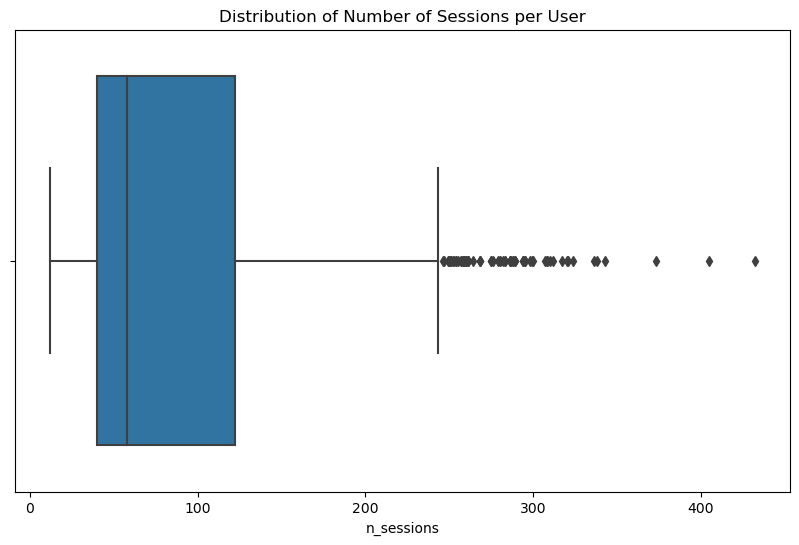

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=session_counts_user_overall)
plt.title('Distribution of Number of Sessions per User')
plt.xlabel('n_sessions')
plt.show()

The following cell outputs the descriptive statistics of this boxplot.

In [19]:
session_counts_per_user_overall_stats = session_counts_user_overall.describe()
IQR = session_counts_per_user_overall_stats['75%'] - session_counts_per_user_overall_stats['25%']
lower_whisker = max(session_counts_per_user_overall_stats['25%'] - 1.5 * IQR, session_counts_per_user_overall_stats['min'])
upper_whisker = min(session_counts_per_user_overall_stats['75%'] + 1.5 * IQR, session_counts_per_user_overall_stats['max'])

print(session_counts_per_user_overall_stats)
print('lw. whisker: ', lower_whisker)
print('up. whisker: ', upper_whisker)

count    3623.000000
mean       85.980955
std        61.417347
min        12.000000
25%        40.000000
50%        58.000000
75%       122.000000
max       432.000000
Name: session_id, dtype: float64
lw. whisker:  12.0
up. whisker:  245.0


There is a wide spread to the data, with 25% of users having between 12 and 40 sessions, whereas the outliers range from having between 245 and 432 sessions per user. Now we further divide this up per set:

In [20]:
# count number of sessions per user per set
session_counts = sessionized_df.groupby(['set', 'userId'])['session_id'].nunique()

# averaging
average_session_counts_per_set = session_counts.groupby(level='set').mean().round(1).reset_index(name='n_sessions')

print("Per set, a user has on average the following number of sessions:")
average_session_counts_per_set

Per set, a user has on average the following number of sessions:


,set,n_sessions
0,test,16.0
1,train,82.6
2,val,15.9


We also want to observe how many interactions 

In [105]:
interactions_per_session_count_y = sessionized_df.groupby(['set', 'userId', 'session_id', 'y']).size().reset_index(name='n_interactions')
avg_interactions_per_session_y = interactions_per_session_count_y.groupby(['set', 'y'])['n_interactions'].mean().round(2).reset_index(name='n_interactions')

print('On average, one user session has the following amounts of interactions wrt. y:')
avg_interactions_per_session_y


On average, one user session has the following amounts of interactions wrt. y:


,set,y,n_interactions
0,test,0,1.29
1,test,1,1.20
2,train,0,3.28
3,train,1,3.43
4,val,0,1.30
5,val,1,1.20


In [104]:
interactions_per_session_count = sessionized_df.groupby(['set', 'userId', 'session_id']).size().reset_index(name='n_interactions')
avg_interactions_per_session = interactions_per_session_count

,set,userId,session_id,n_interactions
0,test,0,0,1
1,test,0,1,1
2,test,0,2,2
3,test,0,3,1
4,test,0,4,1
...,...,...,...,...
414415,val,3622,18,1
414416,val,3622,19,1
414417,val,3622,20,1
414418,val,3622,21,1


We see that the training set approximates well the overall average, and test and validation set have pretty similar numbers due to their similar size. 

In [21]:
# group by itemId and count the sessions for each item
item_sessions_count = sessionized_df_overall.groupby('itemId')['global_session_id'].nunique()

# average sessions per item
avg_sessions_per_item = item_sessions_count.mean().round(1)

print(f"On average, each item appears in {avg_sessions_per_item} sessions across all users.")


On average, each item appears in 1341.8 sessions across all users.


In [22]:
# each global_set_session_id describes one user in a specific session in a specific set
sessionized_df_overall['global_set_session_id'] = sessionized_df_overall['set'].astype(str) + "_" + sessionized_df_overall['userId'].astype(str) + sessionized_df_overall['session_id'].astype(str)

# group by itemid, then by set, and count sessions
item_session_count_per_set = sessionized_df_overall.groupby(['itemId', 'set'])['global_set_session_id'].nunique()

avg_item_session_count_per_set = item_session_count_per_set.groupby(level='set').mean().round(1).reset_index(name='n_sessions')

print("On average, for each set, each item appears in the following number of sessions:")

avg_item_session_count_per_set

On average, for each set, each item appears in the following number of sessions:


,set,n_sessions
0,test,74.1
1,train,1203.0
2,val,74.4


##### **Intra-, and Inter-session repetition rate**

In [23]:
#just for testing purposes
""" file_path_testdata = './data/testdata.csv' # adjust as needed
df_testdata = pd.read_csv(file_path_testdata)

#sessionized
sessionized_testdata = df_testdata.groupby(['userId']).apply(detect_sessions).reset_index(drop=True)

#globally sessionized
sessionized_testdata['global_session_id'] = sessionized_testdata['userId'].astype(str) + "_" + sessionized_testdata['session_id'].astype(str)

sessionized_testdata """

' file_path_testdata = \'./data/testdata.csv\' # adjust as needed\ndf_testdata = pd.read_csv(file_path_testdata)\n\n#sessionized\nsessionized_testdata = df_testdata.groupby([\'userId\']).apply(detect_sessions).reset_index(drop=True)\n\n#globally sessionized\nsessionized_testdata[\'global_session_id\'] = sessionized_testdata[\'userId\'].astype(str) + "_" + sessionized_testdata[\'session_id\'].astype(str)\n\nsessionized_testdata '

In [24]:
# INTRA rep avg
reps_per_item_per_session_intra = sessionized_df_overall.groupby(['userId', 'itemId', 'global_session_id']).size().reset_index(name='n_reps')
#reps_per_item_per_session_intra

reps_per_session = reps_per_item_per_session_intra.groupby('global_session_id')['n_reps'].sum().reset_index(name='n_reps')
#reps_per_session

In [25]:
intra_session_rep_rate = reps_per_session['n_reps'].mean()
intra_session_rep_rate

5.08433143183664

In [26]:
# INTRA rate per set
reps_per_item_per_session_intra_per_set = sessionized_df_overall.groupby(['set', 'userId', 'itemId', 'global_session_id']).size().reset_index(name='n_reps')
#reps_per_item_per_session_intra_per_set

reps_per_session_per_set = reps_per_item_per_session_intra_per_set.groupby(['set', 'global_session_id'])['n_reps'].sum().reset_index(name='n_reps')
#reps_per_session_per_set

In [27]:
intra_session_rep_rate_per_set = reps_per_session_per_set.groupby('set')['n_reps'].mean().reset_index(name='mean_reps')
intra_session_rep_rate_per_set

,set,mean_reps
0,test,1.474155
1,train,4.790931
2,val,1.479704


In [28]:
# INTER rep avg
reps_per_item_per_session_inter = sessionized_df_overall.groupby(['userId', 'itemId', 'global_session_id']).size().reset_index(name='reps')
#reps_per_item_per_session_inter

reps_per_user_across_sessions = reps_per_item_per_session_inter.groupby('userId')['reps'].sum().reset_index(name='reps')
#reps_per_user_across_sessions

In [29]:
inter_session_rep_rate = reps_per_user_across_sessions['reps'].mean().round(2)
inter_session_rep_rate

437.16

In [30]:
#INTER rate per set
reps_per_item_per_session_inter_per_set = sessionized_df_overall.groupby(['set', 'userId', 'itemId', 'global_session_id']).size().reset_index(name='reps')
#reps_per_item_per_session_inter_per_set

reps_per_user_across_sessions_per_set = reps_per_item_per_session_inter_per_set.groupby(['set', 'userId'])['reps'].sum().reset_index(name='reps')
#reps_per_user_across_sessions_per_set

In [31]:
inter_session_rep_rate_per_set = reps_per_user_across_sessions_per_set.groupby('set')['reps'].mean().round(2).reset_index(name='mean_reps')
inter_session_rep_rate_per_set

,set,mean_reps
0,test,22.13
1,train,393.02
2,val,22.00


In [32]:
#avg length per SINGLE user session 

In [33]:
#avg number of interactions per SINGLE user session

•	Total count of user-item interactions per set -> DONE
•	Average count of user-item interactions per user -> DONE
•	Average count of user-item interactions per user per set -> DONE
•	Average count of user-item interactions per item -> DONE
•	Average count of user-item interactions per item per set -> DONE
•	How many repetitions on average per user -> DONE
Session-based measures
•	Total number of sessions -> DONE
•	Average amount of sessions per user -> DONE
•	Average amount of sessions per user, per set -> DONE
•	Average amount of sessions an item is in -> DONE
•	Average amount of sessions an item is in, per session -> DONE
•	How many repetitions per user-session -> INTRA SESSION -> DONE
•	How many repetitions per user across sessions -> INTER SESSION -> DONE
•	Average length of user-session (timestamp)
•	Average number of interactions within one user session

## References

[a] Session-aware recommendation paper

[b] Ex2Vec paper

[c] GRU4Rec paper